# WP - SN1
Aurélien Commans, Martin Pupat, Julia Salinas, Gabriel Rochette, Brendan Corrigan

## 1. Importation des librairires et  des données

In [1]:
from pylab import *
from matplotlib import rc
%matplotlib inline
rc('figure',figsize=(17,10))
rc('font',size=12)
rc('text',usetex=False)
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import cmath as cm
import math
import random
import scipy
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
import pandas
pandas.options.display.float_format = '{:,.2f}'.format
import glob
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy import odr



## Reading file from Google Drive
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Photométrie
!pip install sep
import sep
from matplotlib.patches import Ellipse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00


In [2]:
# Importation des données Test "Test-Data"
download = drive.CreateFile({'id': '1QeWXTbwe60QuH06l18IJ45wv2eBgg62C'})
download.GetContentFile('Test-Data.tgz')
!tar zxvf Test-Data.tgz

# Importation des données "Data-Search"
download = drive.CreateFile({'id': '1F1mFRZFAFCEJumipFGoJr8TJb6oc7naI'})
download.GetContentFile('Data-Search.tgz')
!tar zxvf Data-Search.tgz

./._Test-Data
Test-Data/
Test-Data/EI2019-Test-Data-Field-0_images_epoch_21.58_.fits
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_ 0.53_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_21.58_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-7.89_.csv
Test-Data/EI2019-Test-Data-Field-0_intercal.txt
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-3.68_.csv
Test-Data/EI2019-Test-Data-Field-0_images_epoch_23.68_.fits
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_ 2.63_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_23.68_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_19.47_.csv
Test-Data/._Icon\r
Test-Data/Icon\r
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-1.58_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_27.89_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_13.16_.csv
Test-Data/EI2019-Test-Data-Field-0_images_epoch_15.26_.fits
Test-Data/EI2019-Test-Data-Field-0_images_epoch_17.37_.fits
Test-Data/EI2019-Test-Data-Field-0_images_epoch_19.47_.fits
Test-Data/EI2019-Test-Data-Fiel

In [3]:
# Test - Data

directory0 = 'Test-Data/'
globalName0 = 'EI2019-Test-Data-Field-0'

# Data-Search

directory1 = 'Data-Search/'
globalName1 = 'EI2019-Data-Search-Field-0'
globalName2 = 'EI2019-Data-Search-Field1'
globalName3 = 'EI2019-Data-Search-Field2'
globalName4 = 'EI2019-Data-Search-Field3'
globalName4 = 'EI2019-Data-Search-Field4'

epochs = [-100., -7.89, -5.79, -3.68, -1.58, 0.53, 2.63, 4.74, 6.84, 8.95, 11.05, 13.16, 15.26, 17.37, 19.47, 21.58, 23.68, 25.79, 27.89, 30.]

# Algorithm for images calibration


We have theoretical magnitude data for certain stars in a given field. The relationship linking magnitude and flux is as follows:

$$
M = -2.5 \log_{10}(I) + C
$$

where $ C $ is a constant to be determined, and $ I $ is the flux of each star. Therefore, there is a correspondence between flux and magnitude: by determining the measured flux $ I_{\text{measured}} $ of the stars and comparing it to the theoretical flux $ I_{\text{theory}} = 10^{\frac{C - M}{2.5}} $, a corrective factor $ \beta $ can be determined to be applied for each image:

$$
I_{\text{theory}} = 10^{\frac{C - M}{2.5}} = \beta I_{\text{measured}} \quad (*)
$$

- To determine the value of $ C $, we will calibrate the theoretical data on the image corresponding to a given epoch, assuming $ \beta = 1 $. A linear regression will be performed to obtain$\alpha$ such that: $10^{\frac{-M}{2.5}} = \alpha I_{\text{measured}}$. We will then obtain $C = -2.5 \log_{10} \alpha$.
-  To determine the corrective factor $ \beta $ to be applied for each image, another linear regression will be performed to determine a satisfactory $ \beta $ from equation (*).


The linear regression method guarantees the optimality of the determined parameters.





In [4]:
def photometry_function_SN2(image, x, y, aperture_radius):
    y, x = int(y), int(x)

    # Create a grid of y and x indices
    y_indices, x_indices = np.ogrid[:image.shape[0], :image.shape[1]]
    #y_indices = y_indices[::-1]
    # Calculate the squared distance of each pixel from the center (x, y)
    distance_squared = (x_indices - x)**2 + (y_indices - y)**2
    # Create a mask for the circular aperture
    aperture_mask = distance_squared <= (aperture_radius*10)**2

    # Estimate the background flux in an annulus around the aperture
    annulus_inner_radius = aperture_radius*1.5
    annulus_outer_radius = aperture_radius*2
    annulus_mask = (distance_squared >= (annulus_inner_radius*10)**2) & (distance_squared <= (annulus_outer_radius*10)**2)

    # Calculate the background flux per pixel in the annulus
    background_flux_per_pixel = np.mean(image[annulus_mask])

    # Calculate the total flux within the aperture
    source_flux_total = np.sum(image[aperture_mask])
    # Subtract the background flux from the total flux
    num_pixels_in_aperture = np.sum(aperture_mask)
    background_flux_total = background_flux_per_pixel * num_pixels_in_aperture
    source_flux = source_flux_total - background_flux_total
    sigma_x=np.std(image)
    sigma_i=np.sqrt(num_pixels_in_aperture*sigma_x**2+num_pixels_in_aperture**2/sum(annulus_mask)*sigma_x**2)
    return [source_flux,sigma_i]


def aperture_radius_SN2(directory, globalName, psf, index):
    psf = np.loadtxt(directory+globalName+'_PSF.txt')
    radius = psf[index] / (2*np.sqrt(2 * np.log(2))) *3
    return radius

def ultimate_photometry_SN1(directory,globalName, data_to_input, x_star_list, y_star_list, psf, index):
    psf = np.loadtxt(directory+globalName+'_PSF.txt')
    radius = aperture_radius_SN2(directory,globalName, psf, index)
    list_intensity = []
    list_uncertainty = []
    for k in range(0,len(x_star_list)):
      a = photometry_function_SN2(data_to_input,x_star_list[k],y_star_list[k],radius)
      list_intensity.append(a[0])
      list_uncertainty.append(a[1])
    b = (list_intensity, list_uncertainty)
    return b



In [5]:
# Function for linear regression
def func(x, a):
  return a*x

# Mais function for calibration
def calibration(directory : str = 'Data-Search/', globalname : str = 'EI2019-Data-Search-Field-0'): #Default : Data_search in field 0

    """
    Output : (normalized_factors, normalized_data, SN2_C)

    normalized_factor : dictionnary {epoch : [normalized_factor, error on normalized_factor],...}
    normalized_data : list of all images calibrated, in increasing order of epoch : [img_first_epoch, img_second_epoch,...]
    SN2_C : dictionnary for value of C {epoch : [C, C_erreur],...} (used by SN2)

    """
    model = odr.Model(func)

    psf = np.loadtxt(directory+globalname+'_PSF.txt')


    #Import all FITS file
    files = glob.glob(directory+globalname+'_images_epoch_*.fits')

    # Sort according to epoch
    epochs_img = np.zeros(len(files))
    for i in range(len(files)):
        name = files[i]
        bla = str.split(name,'_')
        epochs_img[i]= bla[-2]

    s = np.argsort(epochs_img)
    epochs = np.zeros(len(files))
    files_sorted = np.zeros_like(files)
    for i in range(len(files)):
        epochs[i] = epochs_img[s[i]]
        files_sorted[i] = files[s[i]]

    #Import data for knows stars
    stars = pandas.read_csv(directory+globalname+'_stars.csv')

    star_data = []
    x_list = []
    y_list = []
    normalized_data=[]
    flux_théorique = []

    for _,row in stars.iterrows() :
      x = float(row['x'])
      y = float(row['y'])
      magnitude = float(row['magnitudes'])
      flux = 10**(-(magnitude)/2.5)
      list = [x,y,magnitude]
      flux_théorique.append(flux)
      star_data.append(list)
      x_list.append(x)
      y_list.append(y)

    normalization_data = {}
    checkpoint = False
    c = 0.0
    index = 0
    hdu_list = fits.open(files_sorted[0])
    data = hdu_list[0].data

    """ Etape 1 : Déterminer C """

    #Retrait du background
    newimg = data.astype(np.float64)
    bkg = sep.Background(newimg)
    data_sub = newimg - bkg
    bkgrms = bkg.rms()

    #Photométrie d'ouverture
    aperture = aperture_radius_SN2(directory, globalname, psf, index)
    needed_data = ultimate_photometry_SN1(directory, globalname, data_sub,x_list,y_list, psf, index)
    flux1 = needed_data[0]
    fluxerr1 = needed_data[1]
    #Regression linéaire
    odr_data = odr.RealData(flux1, flux_théorique, sx=fluxerr1)
    odr_obj = odr.ODR(odr_data, model, beta0=[1])
    output = odr_obj.run()
    popt = [output.beta[0]]
    perr = [output.sd_beta[0]]
    c = -2.5*np.log10(popt[0]) #Calcul de C
    dc = perr[0] *  np.abs(-2.5/(np.log(10)*popt[0]))
    list_temp = []

    for flux in flux_théorique :
        flux = flux * 10**(c/2.5)
        list_temp.append(flux)
    flux_théorique = list_temp

    C_list = []

    """ Etape 2 : Déterminer les coefficients Beta """

    for item in files_sorted :
        hdu_list = fits.open(item)
        data = hdu_list[0].data
        normalized_data.append(data)
        aperture= 1.0
        pixelsize= 0.1 #arcsecond
        nb_sigma = 2
        newimg = data.astype(np.float64)
        bkg = sep.Background(newimg)
        data_sub = newimg - bkg

        #flux
        bkgrms = bkg.rms()
        #Photométrie d'ouverture
        aperture = aperture_radius_SN2(directory, globalname, psf, index)
        needed_data = ultimate_photometry_SN1(directory, globalname, data_sub,x_list,y_list, psf, index)
        flux1 = needed_data[0]
        fluxerr1 = needed_data[1]
        odr_data = odr.RealData(flux1, flux_théorique, sx=fluxerr1)
        odr_obj = odr.ODR(odr_data, model, beta0=[1])
        output = odr_obj.run()
        popt = [output.beta[0]]
        perr = [output.sd_beta[0]]
        x_fit = np.linspace(min(flux1), max(flux1), 1000)
        y_fit = func(x_fit, *popt)
        normalization_data[item] = [popt[0],perr[0]]
        C_list.append([c + 2.5*np.log10(popt[0]),np.abs(dc) + np.abs(2.5*perr[0]/(np.log10(popt[0])*popt[0]))])
        index += 1
    SN2_C = dict(zip(epochs, C_list))
    SN2_C[epochs[0]] = [c,dc]

    y_intercalibration = []
    y_error_intercalibration = []

    for key in normalization_data.keys():
        y_intercalibration.append(normalization_data[key][0])
        y_error_intercalibration.append(normalization_data[key][1])

    Normalization_factor = {}

    for i, item in enumerate(epochs):
        Normalization_factor[item] = [y_intercalibration[i], y_error_intercalibration[i]]

    i = 0
    while i < len(y_intercalibration):
        normalized_data[i] *= y_intercalibration[i]
        i += 1

    return (Normalization_factor, normalized_data, SN2_C)

# Algorithm - Seeing


## Introduction
The images we have in the dataset have been observed over a long period of time. Therefore, we expect different seeing conditions (atmospheric disturbance for instance) on each of those images. Under the effect of those disturbances, the image of stars (which we should see as points) are altered. This is problematic when doing image differencing: our objective is to detect supernovae by substracting an image to a reference to remove all "stationary" objects, but a same star having a different shape on two different images would lead to residual objects in the difference image that would make us detect false SN. It is consequently very important to ensure all similar objects are brought back to a similar shape so that they disappear when we substract images.

## Mathematical procedure

We will think in terms of PSF (Point Scatter Function) which is basically the function that corresponds to the 2D points of the image of the star.

**Hypothesis**:


*   The PSF is a gaussian
*   The gaussian is symetric, so we will run a 1D analysis
*   All stars have the same PSF
All these hypothesis are specific to this EI and are very likely to change in reality, especially the two last ones.

**Procedure**:
The objective is to to substract images A and B, so we want to bring them to the same seeing point. To do so, we will apply a filter to shift the PSF from one of the images to that of the other.
Intuitively, it makes sense to say we will degrade the best image to the worst (the other way around is equivalent to improving the quality of an image out of thin air, which naturally seems wrong). This will later be mathematically verified.
Since the fourier transform of a gaussian is still a gaussian, it makes sense to look for the filter in the form of a gaussian function, i.e: if f and g are gaussians, then  $g*f$ is still a gaussian.

**Looking for the right coefficients**:
We denote $psf_A$ and $psf_B$ the PSF of images A and B, and $PSF_x, \ x=A,B$ the fourier transform.  We assume that A is the worst image, i.e that $\sigma_A \ge \sigma_B$ (the scattering is more important). We note the parameters of each of those functions $\sigma_x, \ \mu_x, \ \ x=A,B$ (respectively the standard deviation and the mean). We are looking for a gaussian function g (parameters $\sigma, \mu$) such that : $$g*psf_B=psf_A$$ (degrading B to A).
Calculations show that:
$$
\begin{cases}
\mu=\mu_A - \mu_B \\
\sigma^2=\sigma_{A}^2-\sigma_{B}^2 \\
\end{cases}
$$
The proof is left as an exercise for the reader.

This function having been identified, we now use scipy's gaussian filter function to apply it to the image, and then proceed to the difference.


## The function

The functions provided executes just this.
- The first function (seeingCorrection) takes as entries the directory and the name of the epoch file in ordre to retrieve and read the PSF for the functions, a list of normalized function to execute the correction, and the number of the epochs to substract (necessary to read the correct PSF). It then determines the worst image, calculate the coefficients of the correction function and applies it. It returns the corrected image AND the number of the image that was corrected.
- The second function (imageDifference) takes the same arguments, executes seeingCorrection, and then checks what image was corrected. This is important: what we want, given two images A and B, is to retrieve the difference between B' and A' where X' is the image X taken on an adapted seeing point. Therefore, the return value will be different if B=B' (B was the worst image) and A' = Corrected, or B'= Corrected and A'=A (A is the worst image). Hence the different cases.



In [6]:
def seeingCorrection(directory, globalName, CalibratedImageList, numA, numB):
    ### Defining the PSF
    # Read the data
    files = glob.glob(directory+globalName+'_images_epoch_*.fits')
    imageA = CalibratedImageList[numA]
    imageB = CalibratedImageList[numB]
    PSF = open(directory+globalName+'_PSF.txt', 'r')
    psf = PSF.readlines()
    #Obtain the sigma
    A_S = float(psf[numA].split()[0])
    B_S = float(psf[numB].split()[0])

    ##If it's acutally the multiplication coefficient!
    A_S = A_S*10/2.355
    B_S = B_S*10/2.355

    #print("A is {valueA}, B is {valueB}".format(valueA=A_S, valueB=B_S))
    #We aim to use the gaussian filter function, so we only need the sigmas.
    ### Calculating correction function
    # Find worse quality image
    if A_S > B_S:
        ref_sigma = A_S
        smaller_sigma = B_S

        toCorrect = imageB
        numCorr=numB
        #print("Worse image is A")
    else:
        ref_sigma = B_S
        smaller_sigma = A_S

        numCorr = numA
        toCorrect = imageA
        #print("Worse image is B")

    # Deduce the correction function
    sigma2= ref_sigma**2 - smaller_sigma**2 #square?

    ### Apply correction
    corrected = gaussian_filter(toCorrect, sigma=np.sqrt(sigma2))
    #print(np.sqrt(sigma2))
    return (corrected, numCorr)


def differenceImage(directory, globalName, CalibratedImageList, numA, numB):
  corrected, numCorr = seeingCorrection(directory, globalName, CalibratedImageList, numA, numB)
  # We have A,B and want to do B'-A' where B' and A' are the images with the same seeing point. The previous code makes either A=A' and B'=corr(B) or B=B' and A'=corr(A), so we need to know
  # which one has been changed to identify the other one
  if numCorr == numA: #If image A has been changed, then image B is unchanged, and we want to do B-A'
    UnchangedImage = CalibratedImageList[numB]
    return UnchangedImage - corrected
  else:
    UnchangedImage = CalibratedImageList[numA]
    return corrected-UnchangedImage



Test sur Data-Search - Field 0 :





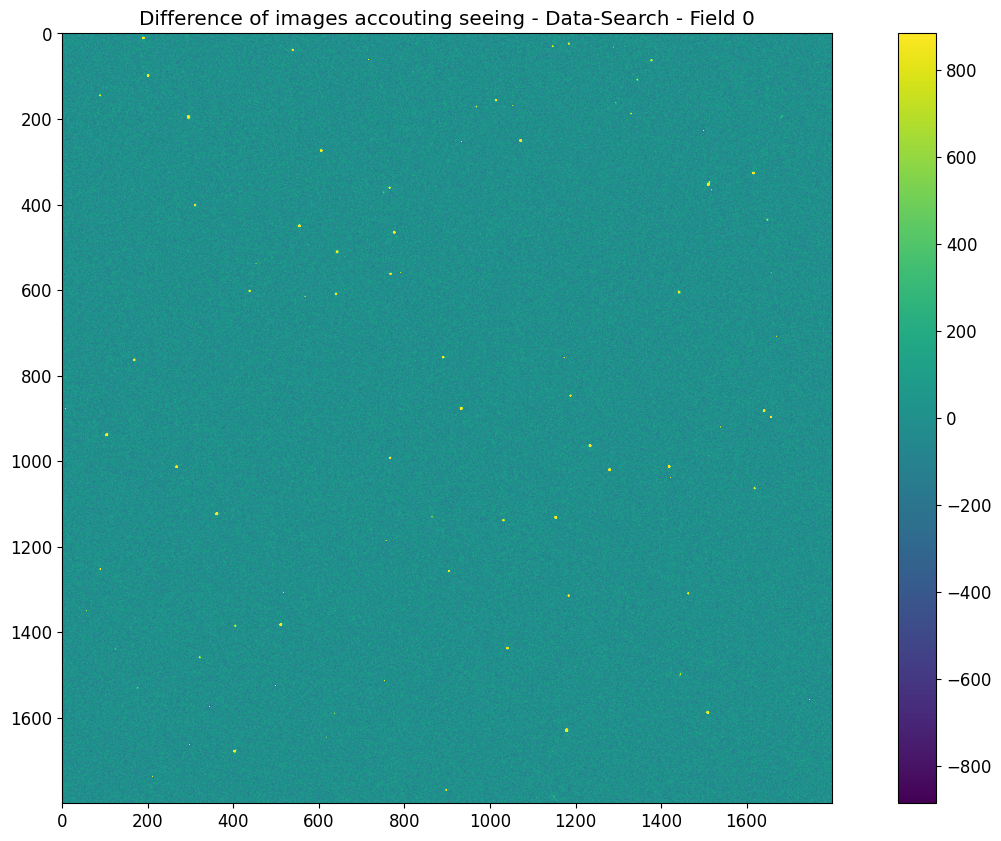

In [7]:
#Calibration
betas, CalibratedList, C_dic = calibration(directory1, globalName1)

#Difference
i = 2 #Index of image to perform substraction (always wrt. epoch -100 where there is no supernovas)
diff = differenceImage(directory1, globalName1, CalibratedList, 0, i)

# Visualisation
plt.imshow(diff,vmin= -3*np.std(diff), vmax = 3*np.std(diff))
plt.title("Difference of images accouting seeing - Data-Search - Field 0")
plt.colorbar()
plt.show()

# Format pour SN2

In [8]:
def calibrated_diff(directory='Data-Search/', globalName = 'EI2019-Data-Search-Field-0'):
  # Retourne toutes les différences d'images calibrées sous la forme d'un dictionnaire {epoch : image calibrée et soustraite à la ref}

  betas, CalibratedList, c = calibration(directory, globalName)
  epochs = [-100., -7.89, -5.79, -3.68, -1.58, 0.53, 2.63, 4.74, 6.84, 8.95, 11.05, 13.16, 15.26, 17.37, 19.47, 21.58, 23.68, 25.79, 27.89, 30.]

  d = {}
  for i in range(1,len(CalibratedList)):
    d[epochs[i]] = differenceImage(directory, globalName, CalibratedList, 0, i)

  return d,c

#Test pour Data-search - field 0
d_image_calibrated,list_c = calibrated_diff()


# Algorithm for supernova detection

We present two different algorithms to detect supernovas. The first one is based on a differecne between two calibrated images accounting the seeing, and the second one is a more precise and global approach, that sums the differences between all images.



## Algorithm 1 - Detect all supernovae on all frames


Quadratic distance function


In [9]:
def quad_distance(x, xc, y, yc):
    return (x-xc)**2 + (y-yc)**2

`add_redshifts_and_gid` : Function that takes coordinates and the list of galaxies with redshifts and gives the nearest galaxy and redshiift associated to the coordinates.

In [10]:
def add_redshifts_and_gid(x, y, galaxies):
  dist_c = math.inf
  r = -math.inf
  g = 0
  for _, row in galaxies.iterrows():
    if quad_distance(x, row["x"], y, row["y"]) < dist_c:
      dist_c = quad_distance(x, row["x"], y, row["y"])
      r = row["redshift"]
      g = row[0]
  return r, g

`supernova_frame_detector` : Function that takes an image and a reference, makes the difference between the two, and detects all the supernovae on the differenced image.

In [11]:
def supernova_frame_detector(directory, globalName, CalibratedList, image, reference):
    # Image sera un tableau de magnitude et reference le tableau initial
    # Out: une liste d'objets extraits sep
    nb_sigma=5
    diff_ = differenceImage(directory, globalName, CalibratedList, reference, image)

    diff_ = diff_.astype(np.float64)
    bkg = sep.Background(diff_)
    diff_ = diff_ - bkg
    objects = sep.extract(diff_, nb_sigma ,err=bkg.globalrms)
    '''
    plt.imshow(diff,vmin= -3*np.std(diff), vmax = 3*np.std(diff))
    plt.colorbar()
    plt.show()
    '''
    return objects

`detect_all_supernovae` : function that takes a list of calibrated images and a list of reference galaxies and returns all supernovae seeings in a table (with duplicates). The returned data is :
- r[i] is a supernova seeing
- r[i][0] is the frame of seeing
- r[i][1] is the ID of the supernova seeing
- r[i][2] is the flux of the seeing
- r[i][3] is the x coordinate of the seeing
- r[i][4] is the y coordinate of the seeing
- r[i][5] is the associated galaxy id of the seeing
- r[i][6] is the redshift of the seeing

In [12]:
def detect_all_supernovae(directory, globalName, CalibratedImageList):
  # reference : l'image FITS initiale sous forme de tableau
  # FITS : une liste d'images FITS sous formes de tableaux
  galaxies = pandas.read_csv(directory+globalName+'_galaxies.csv')
  r = []
  snid = 0
  for frame in range(len(CalibratedImageList)):
    frame_list = supernova_frame_detector(directory, globalName, CalibratedImageList, frame, 0)
    for aster in frame_list:
      snid += 1
      rr = [frame]
      rr.append("SN" + str(snid))
      rr.append(aster["flux"])
      rr.append(aster["x"])
      rr.append(aster["y"])
      red, g = add_redshifts_and_gid(aster["x"], aster["y"], galaxies)
      rr.append(g)
      rr.append(red)
      r.append(rr)
  return r

Let's test `detect_all_supernovae` !




In [13]:
# Test on data-search - field 0

diff = differenceImage(directory1, globalName1, CalibratedList, 0, 2)
res = detect_all_supernovae(directory1, globalName1, CalibratedList)

print(res)

[[1, 'SN1', 65544.5625, 189.86393904108203, 10.903756548239333, 'galaxie 181', 0.7915999889373779], [1, 'SN2', 21295.353515625, 1184.4746179494, 24.220345339393866, 'galaxie 164', 1.1713000535964966], [1, 'SN3', 9621.5, 1146.280133937941, 30.684298757222166, 'galaxie 6', 1.485200047492981], [1, 'SN4', 34190.83984375, 538.7364659697031, 38.853855032515725, 'galaxie 35', 1.010699987411499], [1, 'SN5', 28198.59375, 1377.720773740964, 63.197492399985975, 'galaxie 18', 1.062600016593933], [1, 'SN6', 90623.8515625, 200.85446354121677, 98.91418403961171, 'galaxie 192', 0.7332000136375427], [1, 'SN7', 4775.8544921875, 1344.4908958057506, 108.95769574710552, 'galaxie 173', 1.4940999746322632], [1, 'SN8', 7688.515625, 88.35906838245333, 145.1120534978441, 'galaxie 186', 1.5540000200271606], [1, 'SN9', 64443.46484375, 1013.8756380345035, 156.4728914071376, 'galaxie 95', 0.7990000247955322], [1, 'SN10', 707486.4375, 295.25597863689796, 195.8356524891638, 'galaxie 168', 0.2483000010251999], [1, 'SN

## Algorithm 2: Detection by sum of differences

`find_nova_sum` takes a list of calibrated images, makes an image with the sum of the diffs, and detects supernovae on that image. It returns a list of PSF supernova objects.

You can see below the image on which supernovae were detected.

In [14]:
def find_nova_sum(directory, globalname, CalibratedImageList, nb_sigma):

  image = np.zeros(CalibratedImageList[0].shape)
  PSF = open(directory+globalname+'_PSF.txt', 'r')
  psf = PSF.readlines()

  psf = [i.split()[0] for i in psf]  #list.index(max[list])
  worseImgRef = psf.index(max(psf))
  print()
  alignedImg = []

  for i in range(len(CalibratedImageList)):
    if i == worseImgRef:
      alignedImg.append(CalibratedImageList[i])
    else:
      corrected, numCorr = seeingCorrection(directory, globalname, CalibratedImageList, worseImgRef, i)
      alignedImg.append(corrected)

  ReferenceImage=alignedImg[0]
  for i in range(len(CalibratedImageList)-1):
    image += alignedImg[i+1]-ReferenceImage #Warning! Not 0

  image = image.astype(np.float64)
  bkg = sep.Background(image)
  novas = sep.extract(image-bkg, nb_sigma ,err=bkg.globalrms)

  print("Nombre de supernovas", len(novas['x']))

  return image, novas





Nombre de supernovas 59


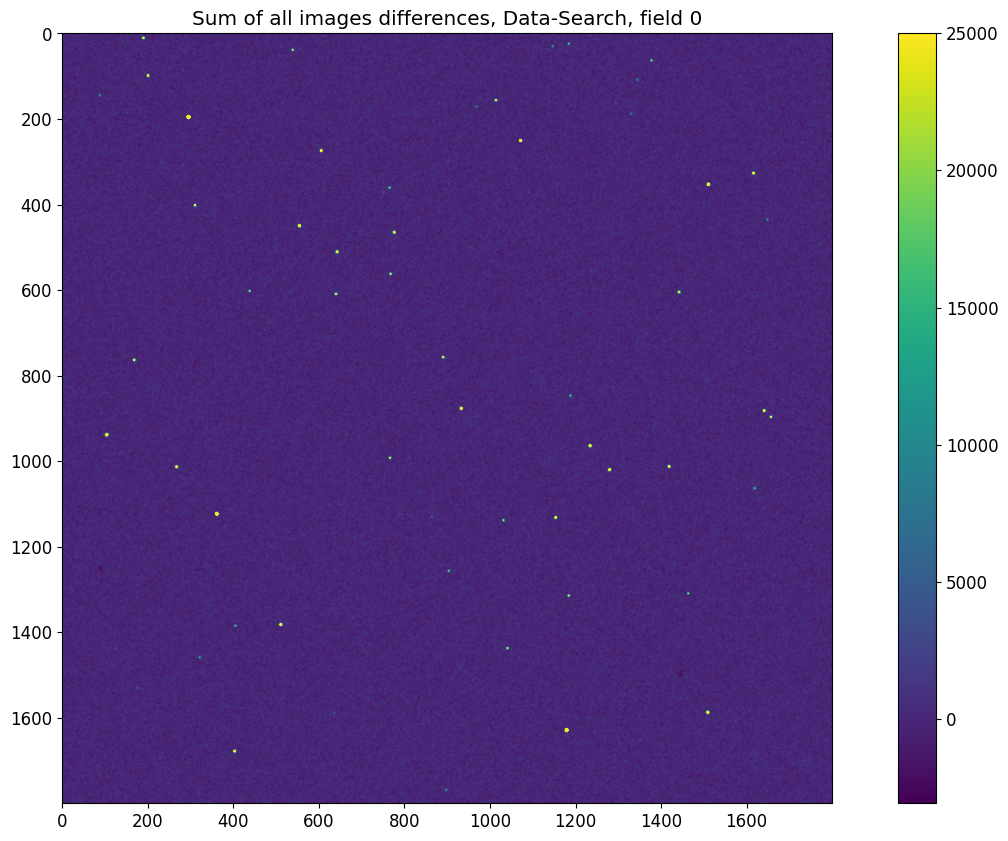

In [15]:
#Test sur Data search - field 0

image, novas = find_nova_sum(directory1, globalName1, CalibratedList,5)

plt.imshow(image,vmax=25000)
plt.colorbar()
plt.title("Sum of all images differences, Data-Search, field 0")
xlist= novas['x']
ylist= novas['y']

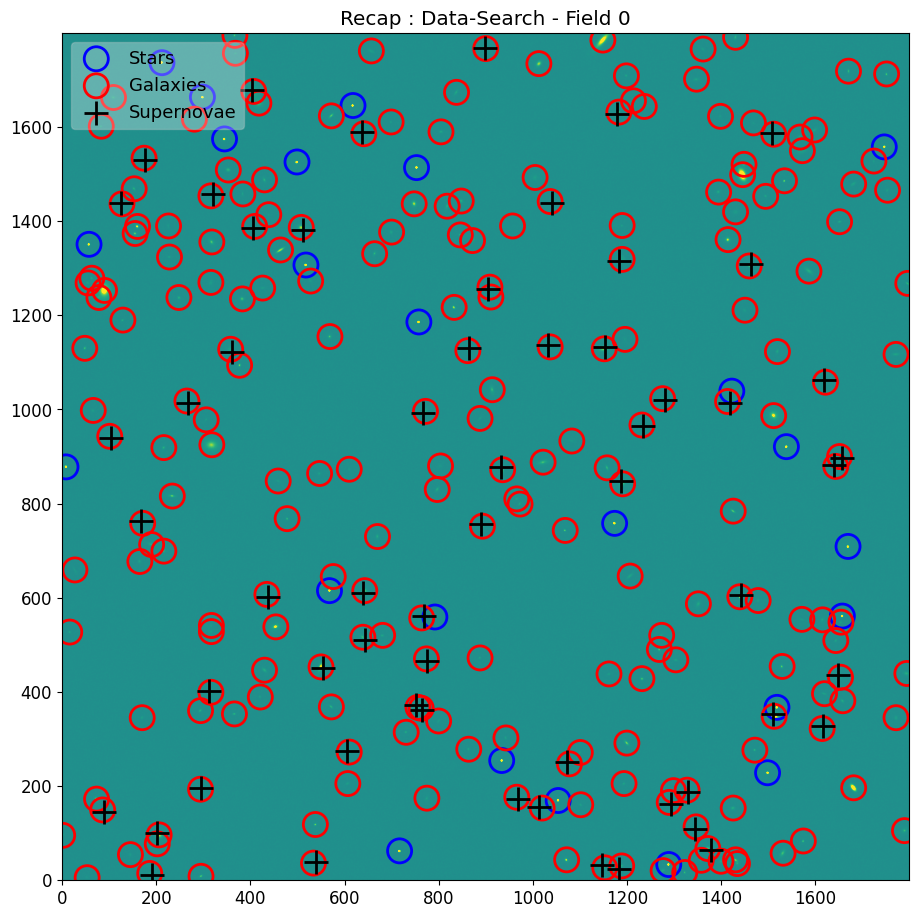

In [16]:
galaxies = pandas.read_csv(directory1+globalName1+'_galaxies.csv')
stars = pandas.read_csv(directory1+globalName1+'_stars.csv')

plt.figure(figsize=(11,11))
imshow(CalibratedList[0], origin='lower', vmin= -3*np.std(image), vmax = 3*np.std(image))

### Stars
plt.scatter(np.around(stars['x'].values), np.around(stars['y'].values),
            s=300, marker='o', facecolors='none', edgecolors='b', lw=2,
            label='Stars')

### Galaxies
plt.scatter(np.around(galaxies['x'].values), np.around(galaxies['y'].values),
            s=300, marker='o', facecolors='none', edgecolors='r', lw=2,
            label='Galaxies')

### Supernovae
plt.scatter(np.around(novas['x']), np.around(novas['y']),
            s=300, marker='+', color='k', lw=2,
            label='Supernovae')

legend(loc='upper left', fontsize=13, framealpha=0.3)
title("Recap : Data-Search - Field 0")
plt.show()

`match_supernova` takes a supernova seeing from `detect_all_supernovae` and matches it with a supernova from `find_nova_sum`.

Then, `detect_filtered_supernovae` gives takes the image list and the galaxies list and returns a list of supernovae, taken from `find_nova_sum`, and corroborates it with seeings from `detect_all_supernovae`.

- r[i] is a given supernova
- r[i][0] is the supernova ID
- r[i][1] is the flux of the supernova according to the sum-of-differences image
- r[i][2] is the supernova's x-position according to the difference sum image
- r[i][3] is the y-position of the supernova according to the difference sum image
- r[i][4] is the connecting galaxy
- r[i][5] is the redshift
- r[i][6] is the list of epoch indices at which the detect_all_supernovae code saw the supernova

In [17]:
def match_supernova(x, y, match_list):
  c = 0
  dist_c = math.inf
  for i in range(len(match_list)):
    d = quad_distance(x, match_list[i][2], y,  match_list[i][3])
    if d < dist_c :
      dist_c = d
      c = i
  return c

def detect_filtered_supernovae(directory, globalName, CalibratedImageList, nb_sigma=5):
  # Output : un tableau r tel que
  # r[i][0] est l'ID de la supernova
  # r[i][1] est le flux de la supernova d'après l'image de la somme des différences
  # r[i][2] est la position x de la supernova d'après l'image de la somme des différences
  # r[i][3] est la position y de la supernova d'après l'image de la somme des différences
  # r[i][4] est la galaxie de rattachement
  # r[i][5] est le redshift
  # r[i][6] est la liste des indices des époques auxquelles le code detect_all_supernovae a vu la supernova

  galaxies = pandas.read_csv(directory+globalName+'_galaxies.csv')

  all_supernovae = detect_all_supernovae(directory, globalName, CalibratedImageList)
  _, match_list = find_nova_sum(directory, globalName, CalibratedImageList, nb_sigma)

  r = []
  snid = 0
  for aster in match_list:
    snid += 1
    rr = []
    rr.append("SN" + str(snid))
    rr.append(aster["flux"])
    rr.append(aster["x"])
    rr.append(aster["y"])
    red, g = add_redshifts_and_gid(aster["x"], aster["y"], galaxies)
    rr.append(g)
    rr.append(red)
    rr.append([])
    r.append(rr)
  for asters in all_supernovae:
    c = match_supernova(asters[3], asters[4], r)
    r[c][-1].append(asters[0])
  return r


Final test on Data-Search - Field 0

In [18]:
final_result = detect_filtered_supernovae(directory1, globalName1, CalibratedList)

# Exemple : properties of first supernova
print(final_result[0])


Nombre de supernovas 59
['SN1', 1181457.75, 189.8898039245901, 10.882772118672936, 'galaxie 181', 0.7915999889373779, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]


### Pour SN2 et SN3 : ligne de code pour récupérer les x,y, redshift (qui matchent)

In [19]:
redshift = [final_result[i][5] for i in range(len(final_result))]
xlist = [final_result[i][2] for i in range(len(final_result))]
ylist = [final_result[i][3] for i in range(len(final_result))]

print("Redshift", redshift)
print("Positions x", xlist)
print("Positions y", ylist)

Redshift [0.7915999889373779, 1.1713000535964966, 1.485200047492981, 1.010699987411499, 1.062600016593933, 0.7332000136375427, 1.4940999746322632, 1.5540000200271606, 0.7990000247955322, 2.601900100708008, 1.8288999795913696, 1.6865999698638916, 0.2483000010251999, 0.5457000136375427, 0.7324000000953674, 0.6604999899864197, 0.3594000041484833, 1.4443000555038452, 2.095900058746338, 0.7457000017166138, 1.6755000352859497, 0.5062000155448914, 0.7110999822616577, 0.6241999864578247, 0.9729999899864196, 1.170699954032898, 0.6121000051498413, 0.930299997329712, 0.7368999719619751, 0.871999979019165, 1.090999960899353, 0.5683000087738037, 0.7343000173568726, 0.8867999911308289, 0.4997999966144562, 0.550599992275238, 0.9312999844551086, 0.6402000188827515, 0.75, 0.5509999990463257, 1.2924000024795532, 0.382099986076355, 1.854599952697754, 0.5990999937057495, 0.9765999913215636, 1.145300030708313, 1.205399990081787, 0.986299991607666, 0.6039999723434448, 1.2768000364303589, 2.2827999591827397,

## To go further

Let's see what our 5 Data-Serch fiels look like:


Nombre de supernovas 57


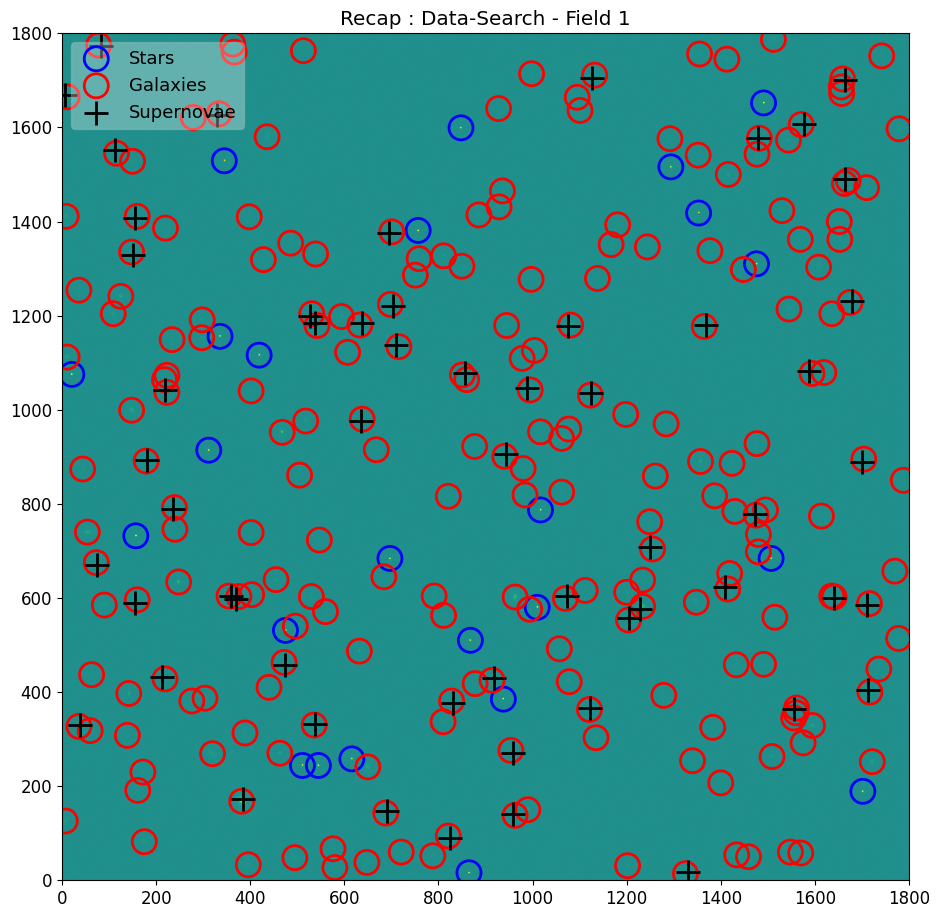


Nombre de supernovas 57


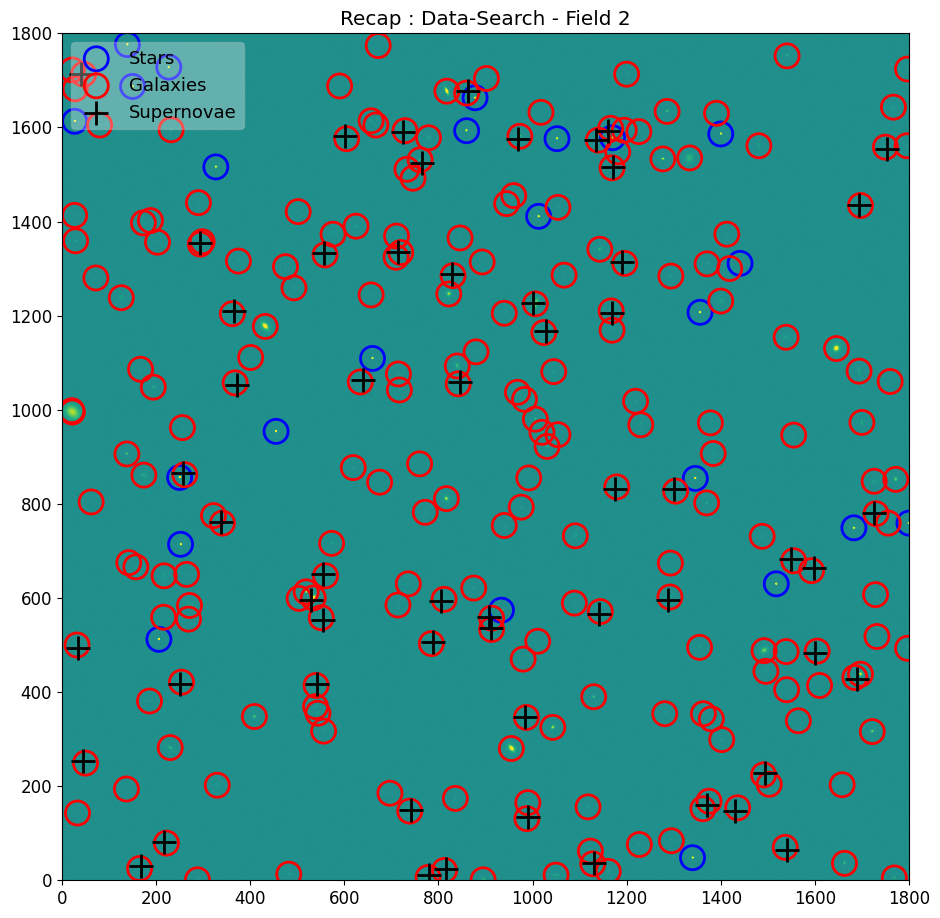


Nombre de supernovas 58


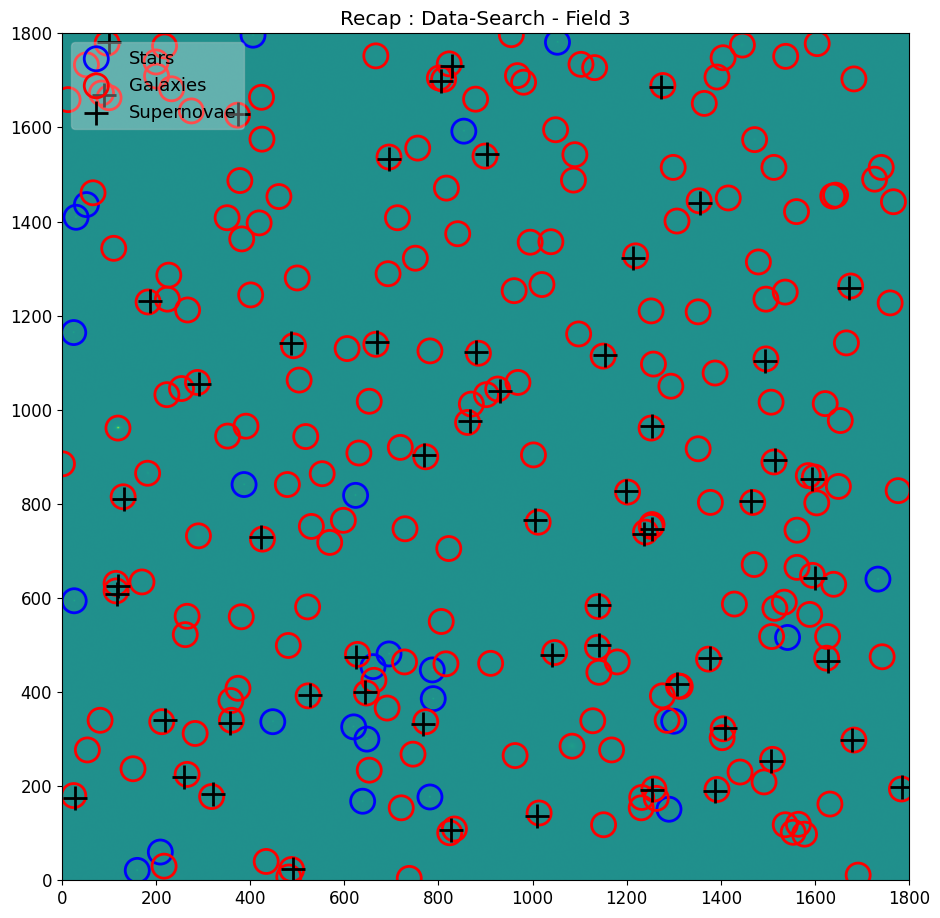


Nombre de supernovas 60


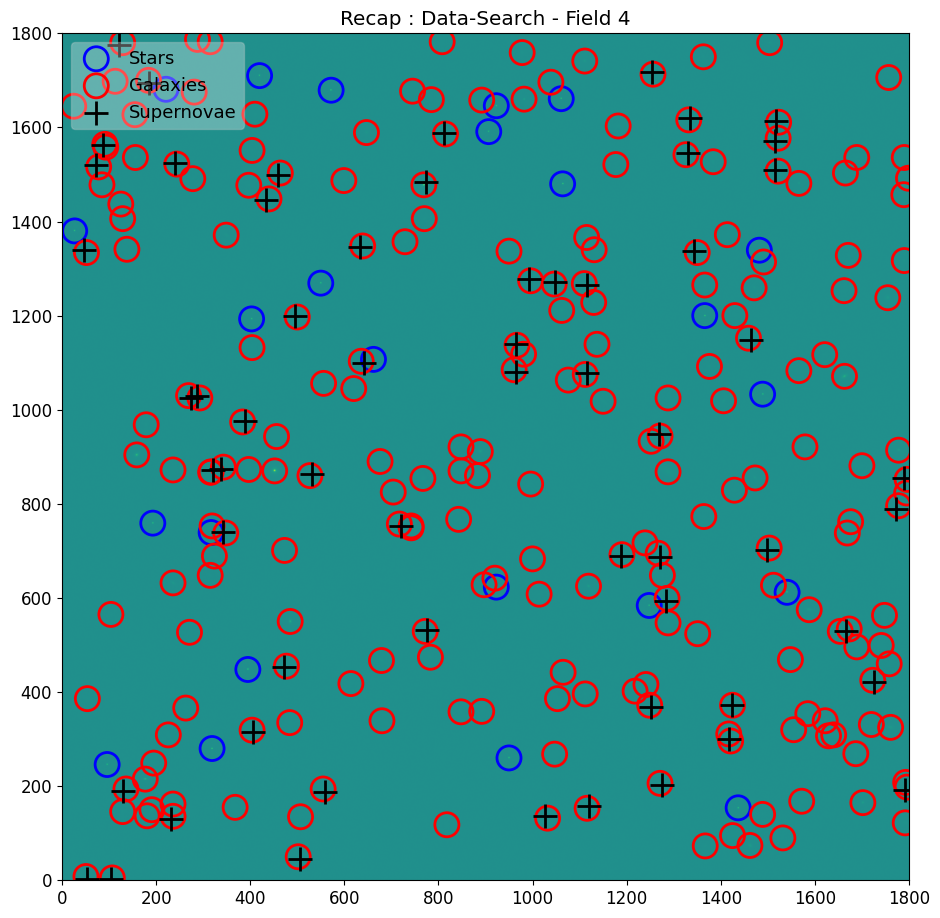

In [20]:
for i in range(1,5):
  'EI2019-Data-Search-Field-'+str(i)

  betas, CalibratedList, C_dic = calibration(directory1, 'EI2019-Data-Search-Field-'+str(i))

  image, novas = find_nova_sum(directory1, 'EI2019-Data-Search-Field-'+str(i), CalibratedList,5)

  galaxies = pandas.read_csv(directory1+'EI2019-Data-Search-Field-'+str(i)+'_galaxies.csv')
  stars = pandas.read_csv(directory1+'EI2019-Data-Search-Field-'+str(i)+'_stars.csv')

  plt.figure(figsize=(11,11))
  imshow(CalibratedList[0], origin='lower', vmin= -3*np.std(image), vmax = 3*np.std(image),extent=[0,CalibratedList[0].shape[0],0,CalibratedList[0].shape[0]])

  ### Stars
  plt.scatter(np.around(stars['x'].values), np.around(stars['y'].values),
              s=300, marker='o', facecolors='none', edgecolors='b', lw=2,
              label='Stars')

  ### Galaxies
  plt.scatter(np.around(galaxies['x'].values), np.around(galaxies['y'].values),
              s=300, marker='o', facecolors='none', edgecolors='r', lw=2,
              label='Galaxies')

  ### Supernovae
  plt.scatter(np.around(novas['x']), np.around(novas['y']),
              s=300, marker='+', color='k', lw=2,
              label='Supernovae')

  legend(loc='upper left', fontsize=13, framealpha=0.3)
  title("Recap : Data-Search - Field "+str(i))
  plt.show()





# Final extraction of all supernova data

**Warning** : the two following cells are take a really long time to execute (photometry code non-optimized)


In [21]:
def calibrated_diff(directory='Data-Search/', globalName = 'EI2019-Data-Search-Field-0'):
  # Retourne toutes les différences d'images calibrées sous la forme d'un dictionnaire {epoch : image calibrée et soustraite à la ref}

  betas, CalibratedList, c = calibration(directory, globalName)
  epochs = [-100., -7.89, -5.79, -3.68, -1.58, 0.53, 2.63, 4.74, 6.84, 8.95, 11.05, 13.16, 15.26, 17.37, 19.47, 21.58, 23.68, 25.79, 27.89, 30.]

  d = {}
  for i in range(1,len(CalibratedList)):
    d[epochs[i]] = differenceImage(directory, globalName, CalibratedList, 0, i)

  return CalibratedList,d,c

list_calibrated_all_fields = []
list_c_all_fields = []
list__ = []

for i in range(5):
  print("Field"+str(i))
  directory='Data-Search/'
  globalName ='EI2019-Data-Search-Field-'+str(i)
  CalibratedList,d_image_calibrated,list_c = calibrated_diff(directory,globalName)
  list_calibrated_all_fields.append(d_image_calibrated)
  list_c_all_fields.append(list_c)
  list__.append(CalibratedList)

Field0
Field1
Field2
Field3
Field4


In [22]:
all_redshift = []
all_xlist = []
all_ylist = []

for i in range(5):
  print("Field"+str(i)+" Done")
  directory='Data-Search/'
  globalName ='EI2019-Data-Search-Field-'+str(i)

  final_result = detect_filtered_supernovae(directory, globalName, list__[i])
  all_redshift.append([final_result[i][5] for i in range(len(final_result))])
  all_xlist.append([final_result[i][2] for i in range(len(final_result))])
  all_ylist.append([final_result[i][3] for i in range(len(final_result))])


Field0 Done

Nombre de supernovas 59
Field1 Done

Nombre de supernovas 57
Field2 Done

Nombre de supernovas 57
Field3 Done

Nombre de supernovas 58
Field4 Done

Nombre de supernovas 60


In [23]:
redshift_concatenate = []

for i in range(5):
  r = all_redshift[i]
  for z in r:
    redshift_concatenate.append(r)



# WP: SN2

In [24]:
print(all_xlist[0])

[189.8898039245901, 1184.3646550656308, 1146.5014096880036, 538.7468515355785, 1377.5875295985786, 200.84939485045606, 1344.533008738552, 88.38621291819996, 1013.8886361004938, 1293.915896656816, 968.1053077970994, 1329.7598905783548, 295.25961801946073, 1071.6413783911485, 605.4927547570016, 1616.0630172631627, 1510.5895203962834, 765.2491754877859, 751.5076621083872, 310.56919397956864, 1648.4796259971904, 554.6430634855348, 776.1434777080509, 642.5699714338514, 767.5221251516355, 438.0293645812139, 1442.0020215255208, 640.0283748561893, 890.6697929559779, 168.45672514643823, 1188.204422630095, 932.8244499420096, 1640.9841632063265, 1656.6140278140533, 104.22539088669716, 1234.0149903027511, 766.4181366870578, 1418.829072862022, 267.4470767024611, 1279.5877221845303, 1618.6111063604937, 361.43569474717447, 864.4015694328303, 1153.5890859989972, 1031.6005656246844, 903.9914356184614, 1463.4774837480757, 1183.9698488917943, 510.99772896165456, 404.6745880031411, 123.83669285892054, 104

In [27]:
def imaxi(liste):
    maxi = liste[0]
    longueur=len(liste)
    indice_max = 0
    for i in range(longueur):
        if liste[i] >= maxi:
            maxi = liste[i]
            indice_max = i
    return indice_max

def photometry_function(image, x, y, aperture_radius, calibration_factor=1.0,C=0):
    y, x = int(y), int(x)

    # Create a grid of y and x indices
    y_indices, x_indices = np.ogrid[:image.shape[0], :image.shape[1]]
    #y_indices = y_indices[::-1]
    # Calculate the squared distance of each pixel from the center (x, y)
    distance_squared = (x_indices - x)**2 + (y_indices - y)**2
    # Create a mask for the circular aperture
    aperture_mask = distance_squared <= (aperture_radius*10)**2

    # Estimate the background flux in an annulus around the aperture
    annulus_inner_radius = aperture_radius*1.5
    annulus_outer_radius = aperture_radius*2
    annulus_mask = (distance_squared >= (annulus_inner_radius*10)**2) & (distance_squared <= (annulus_outer_radius*10)**2)

    # Calculate the background flux per pixel in the annulus
    background_flux_per_pixel = np.mean(image[annulus_mask])

    # Calculate the total flux within the aperture
    source_flux_total = np.sum(image[aperture_mask])
    # Subtract the background flux from the total flux
    num_pixels_in_aperture = np.sum(aperture_mask)
    background_flux_total = background_flux_per_pixel * num_pixels_in_aperture
    source_flux = source_flux_total - background_flux_total
    sigma_x=np.std(image)
    sigma_i=np.sqrt(num_pixels_in_aperture*sigma_x**2+num_pixels_in_aperture**2/sum(annulus_mask)*sigma_x**2)
    sigma_m=np.sqrt((2.5*sigma_i)**2/(source_flux*np.log(10))**2)
    # Convert the total flux to magnitude using the calibration factor
    if source_flux <= 0:
        magnitude = np.inf
        print("erreur")
    else:
        magnitude = -2.5 * np.log10(source_flux_total / calibration_factor)+C
    return [-magnitude,sigma_m]


def aperture_radius(psf):
    radius = psf / (2*np.sqrt(2 * np.log(2))) *3
    return radius

#Plot the lightcurves of all detected supernovae
dico={}
count=0
for j in range(len(all_xlist)):
  print(j)

  directory='Data-Search/'
  globalName ='EI2019-Data-Search-Field-'+str(j)
  psf = np.loadtxt(directory1+globalName1+'_PSF.txt')
  xlist = all_xlist[j]
  ylist = all_ylist[j]
  d_image_calibrated = list_calibrated_all_fields[j]
  list_c = list_c_all_fields[j]


  for sn in range (len(xlist)):
    tab=[]
    tab_2=[]
    sigma=[]
    count +=1
    for i in range (1,19):
      # tab.append(photometry_function(d_image_calibrated[epochs[i]], xlist[39], ylist[39], aperture_radius(psf[i]))[0]) #Sans C
      tab.append(photometry_function(d_image_calibrated[epochs[i]], xlist[sn], ylist[sn], aperture_radius(psf[i]), C=list_c[-100][0])[0]) #Avec C
      sigma.append(photometry_function(d_image_calibrated[epochs[i]], xlist[sn], ylist[sn], aperture_radius(psf[i]))[1])
      v=[epochs[i]]+photometry_function(d_image_calibrated[epochs[i]], xlist[sn], ylist[sn], aperture_radius(psf[i]),C=list_c[epochs[i]][0])
      tab_2.append(v)
    dico[count]=tab_2
    # plt.plot(epochs[1:len(epochs)-1],tab)
    # plt.errorbar(epochs[1:len(epochs)-1], tab, yerr=sigma,fmt='.', capsize=5, label='Mesures')
    # plt.title("LightCurve of SN"+str(sn))
    # plt.xlabel("epochs")
    # plt.ylabel("-magnitude")
    # plot([epochs[imaxi(tab)+1],epochs[imaxi(tab)+1]], [min(tab),max(tab)], 'g--', label='Date of Maximum')
    # plt.show()






#dico est un dictionnaire dont les clés sont les numéros des supernova et les valeurs sont des tableaux 2D dont chaque ligne est [epoch,magnitude,incertitude]
#exemple : {0: [[epoch1, m1, i1]
#               [epoch2, m2, i2]
#              ...
#               [epoch18, m18, i18]],
#           1: [[epoch1, m1, i1]
#etc...

0
1
2
3
4


In [28]:
print(len(dico))

291


# WP: SN3

In [30]:
#fir with minuit (mu as a function of z)
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import random as rd
!pip install emcee
!pip install iminuit


#### Import cosmolib
!rm -rf cosmolib.py*
!wget --no-check-certificate https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/cosmolib.py
import cosmolib as cs

  Using cached emcee-3.1.6-py2.py3-none-any.whl (47 kB)
--2024-06-07 10:04:08--  https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/cosmolib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16741 (16K) [text/plain]
Saving to: ‘cosmolib.py’

cosmolib.py         100%[===================>]  16.35K  --.-KB/s    in 0.001s  

2024-06-07 10:04:08 (29.3 MB/s) - ‘cosmolib.py’ saved [16741/16741]



In [31]:
%%capture --no-display
##### For Data-LightCurves (WP-SN-3):
download = drive.CreateFile({'id': '1Ih8AQsMCmSESWytcztyJKGVvnP_-VAsC'})
download.GetContentFile('Data-LightCurves.tgz')
!tar zxvf Data-LightCurves.tgz
!ls -lrt

In [32]:
%%capture --no-display
t_ref, mag_ref = np.loadtxt('Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T
print("Longueur de dico: ",len(dico))
print("dico = ")
for i in range(len(dico)):
  print(dico[i])

KeyError: 0

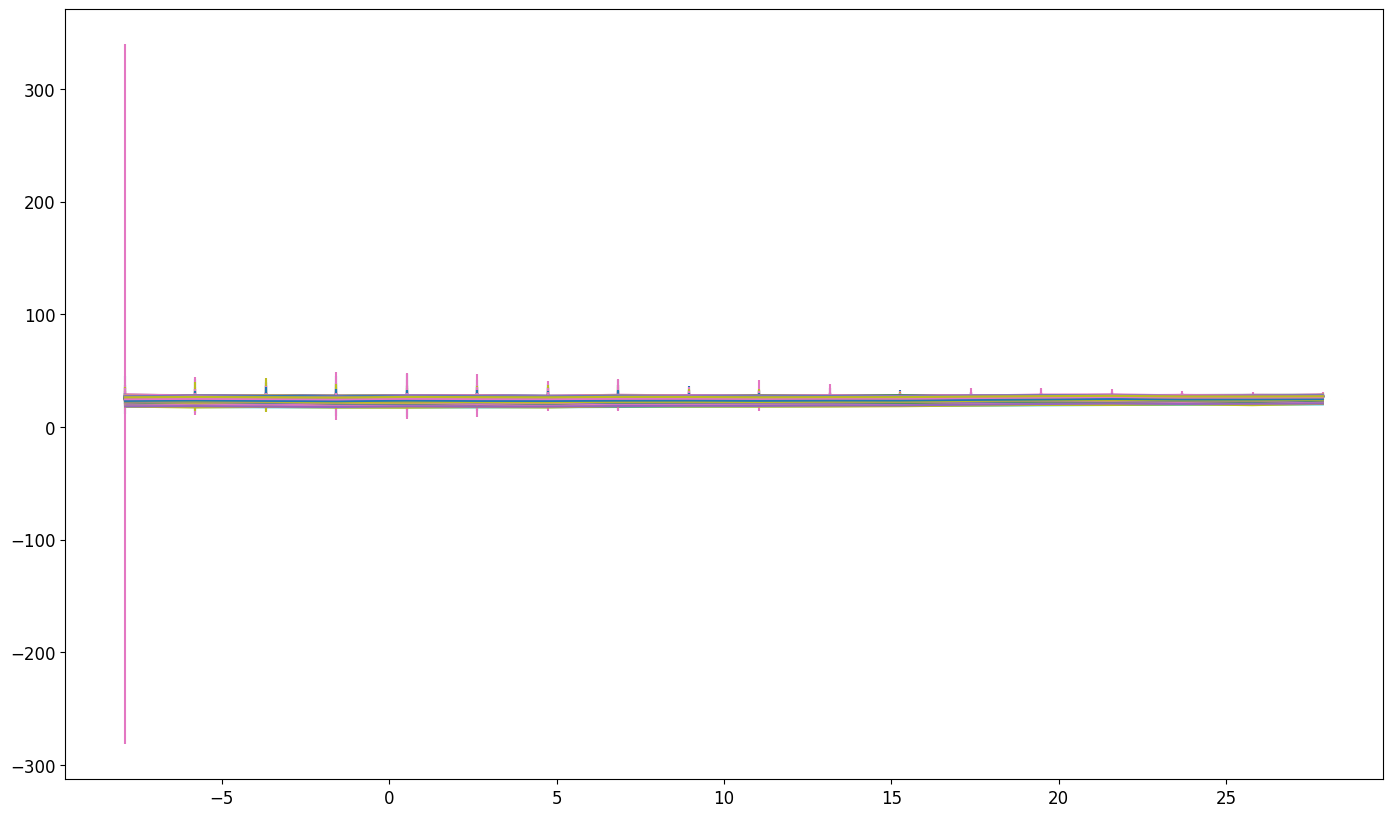

In [40]:
%%capture --no-display
to_graph_t0=[]
to_graph_s = []
to_graph_mu = []
sigma_mu = []
sigma_s = []
chi_2 = []

L_z_prec = []
for sublist in all_redshift:
    L_z_prec.extend(sublist)
L_z = []

print(len(dico))

for i in range(1,len(dico)):
  z = L_z_prec[i]
  print(z)
  # tobs,mobs,err = np.loadtxt(f'Data-LightCurves/EI2019-Data-LightCurves-SN-{i}_lightcurve.txt').T
  L_triplets = np.array(dico[i])
  tobs = L_triplets[:,0]
  mobs = -L_triplets[:,1]
  err = L_triplets[:,2]

  # tmin = tobs[0]
  # tmax = tobs[-1]
  # ttt = np.linspace(tmin, tmax, 1000)
  # mobs = np.interp(ttt,tobs,mobs,left = 0, right = 0)
  # ttt = np.linspace(-100,200,1000)
  def calc_mth_cut(t,pars):            # pars = [s,mu,t0]
      return np.interp(t,(t_ref-pars[2])*pars[0]*(1+z),mag_ref+pars[1]-1.52*(pars[0]-1))

  for mu_guess in [35,45]:
    guess = np.array([1,mu_guess,-5])
    result = cs.do_minuit(tobs, mobs, np.sqrt(err**2 + 0.12**2), guess, functname=calc_mth_cut)
    if mu_guess == 35:
      chi_35 = result[-2]
    elif result[-2] > chi_35:
      guess = np.array([1,35,-5])
      result = cs.do_minuit(tobs, mobs, np.sqrt(err**2 + 0.12**2), guess, functname=calc_mth_cut)
  # guess = np.array([1,45,-5])
  # result = cs.do_minuit(tobs, mobs, err, guess, functname=calc_mth_cut)
  sigma_mu_i = result[-4][1]
  mu_i = result[-5][1]
  sigma_s_i = result[-4][0]
  s_i = result[-5][0]
  sigma_s.append(result[-4][0])
  if mu_i/sigma_mu_i < 800 and s_i/sigma_s_i< 800:
    to_graph_t0.append(result[-5][2])
    to_graph_s.append(s_i)
    to_graph_mu.append(mu_i)
    sigma_mu.append(sigma_mu_i)
    chi_2.append([result[-2], i])
    L_z.append(z)

  plt.errorbar(tobs,mobs,err)
  plt.plot(tobs,calc_mth_cut(tobs,[s_i,mu_i,result[-5][2]]))
# plt.plot(t_ref,mag_ref)
plt.show()


to_graph_s = np.array(to_graph_s)
to_graph_mu = np.array(to_graph_mu)
sigma_mu = np.array(sigma_mu)
L_z = np.array(L_z)

Text(0, 0.5, '$\\mu$ ')

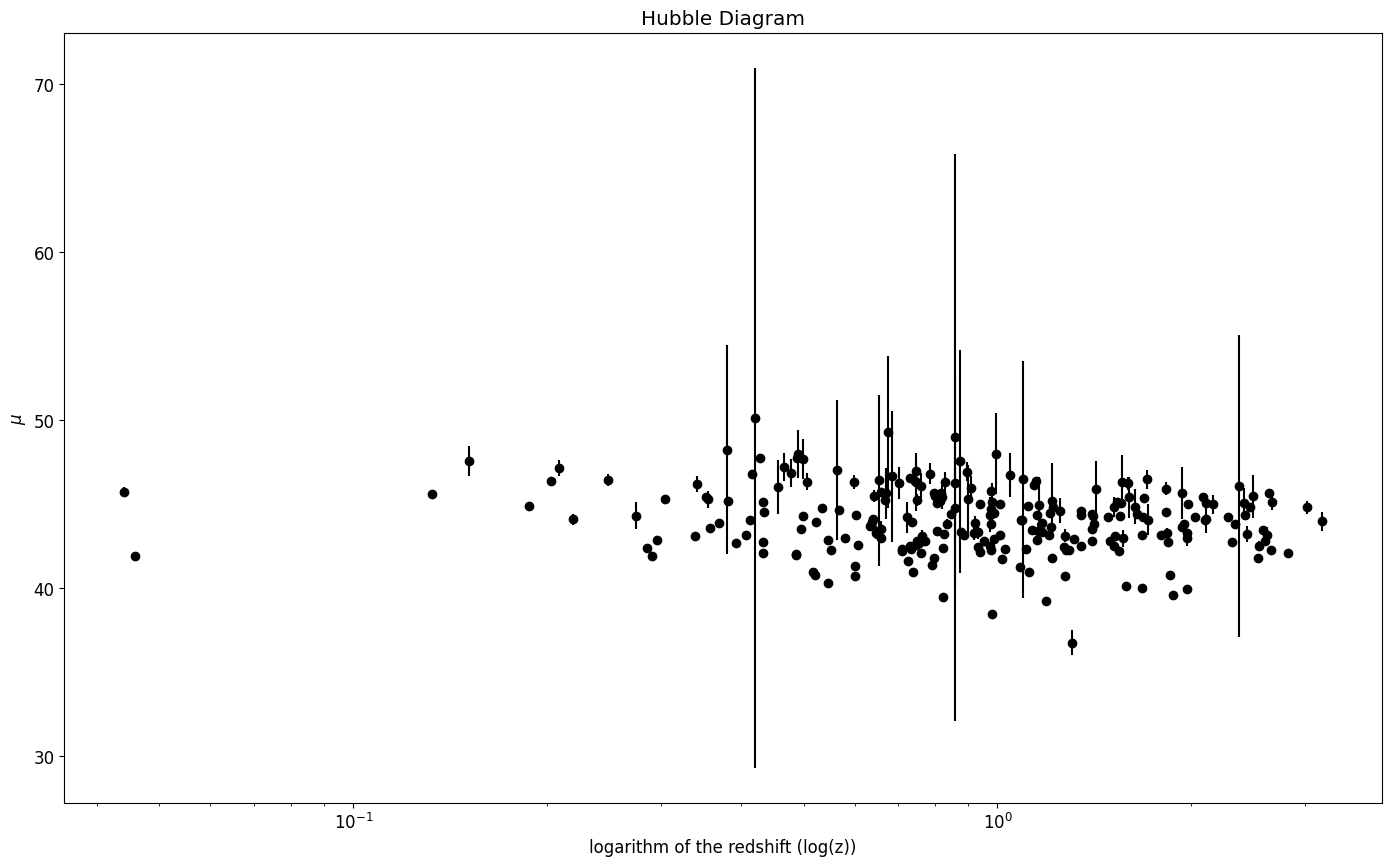

In [41]:
plt.errorbar(L_z,to_graph_mu,yerr = sigma_mu, fmt='ko')
xlabel('z')
ylabel('mu')
xscale('log')
title('Hubble Diagram')
xlabel('logarithm of the redshift (log(z))')
ylabel(r'$\mu$ ')

[165.6628297321196, 150]


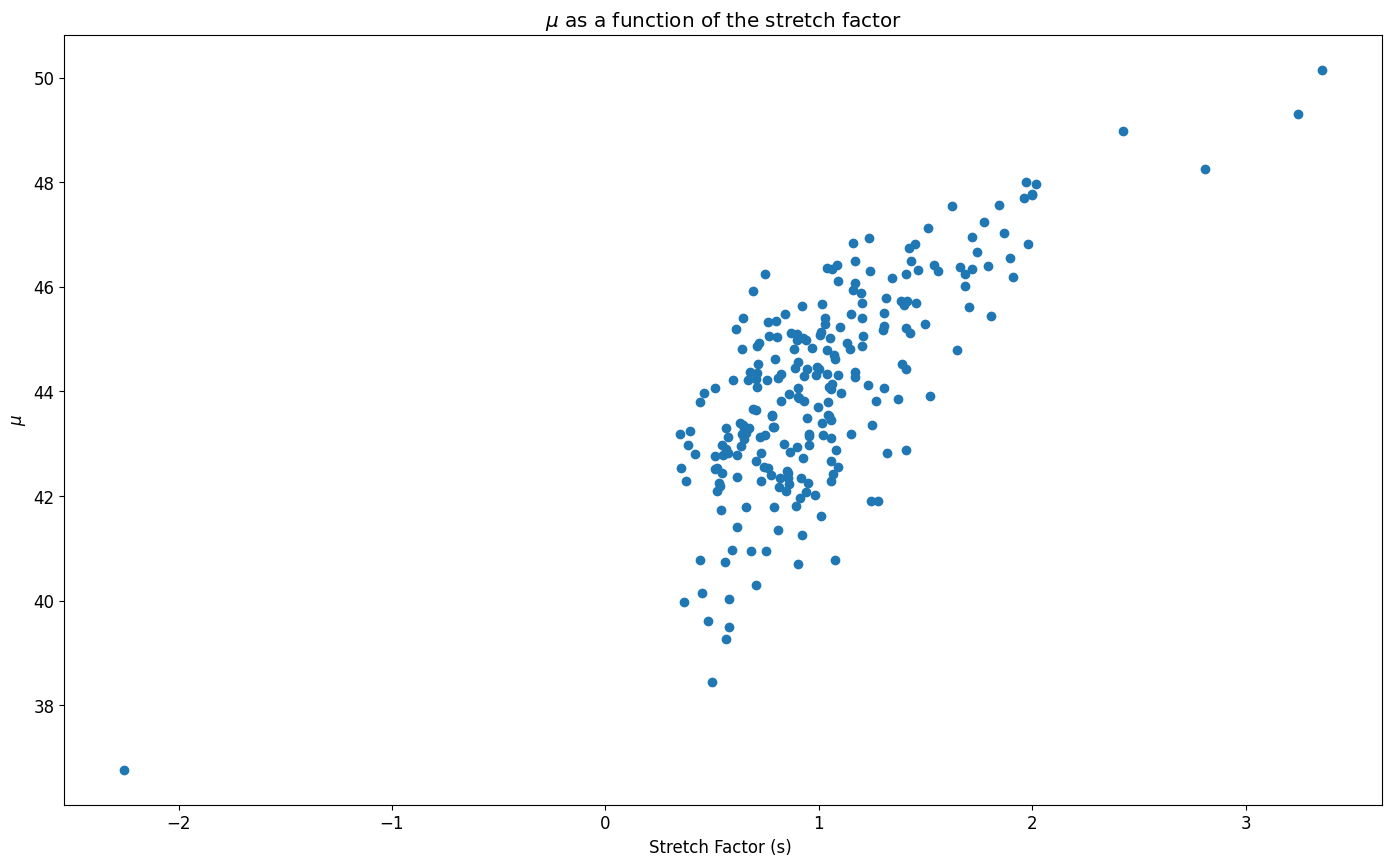

In [42]:
plot(to_graph_s, to_graph_mu, 'o', )
xlabel('Stretch Factor (s) ')
ylabel(r'$\mu$')
title(r'$\mu$ as a function of the stretch factor')
print(max(chi_2))

In [54]:
def muprevMCMC(x, pars):
    cosmo = {'h':pars[0], 'omega_M_0':pars[1],
             'omega_lambda_0':pars[2], 'w0':pars[3]}
    val = cs.musn1a(x, cosmo)
    # plt.plot(x,val)
    val[isnan(val)] = -1e30
    return val

guess = np.array(([0.7, 0.3,0.7,-1]))

result = cs.do_minuit(L_z, to_graph_mu, sigma_mu, guess, functname=muprevMCMC, fixpars=[0,3])

guess = result[-5]
data = cs.Data(L_z, to_graph_mu, sigma_mu,muprevMCMC)

chain = data.run_mcmc(guess, nbmc=1000, allvariables=['h','om','ol','w'],fixpars=[0,3], nsigmas = 1e-10, nwalkers = 10)

Fitting with Minuit
Chi2 = 71831.46603841364
ndf = 240
Fitted values:
[ 0.7         2.06665279  2.91105361 -1.        ]
Errors:
[0.007      0.02096578 0.01082884 0.01      ]
Covariance:
[[0.         0.         0.         0.        ]
 [0.         0.00043956 0.00021987 0.        ]
 [0.         0.00021987 0.00011726 0.        ]
 [0.         0.         0.         0.        ]]
fixpars [0, 3]
self.fixedpars [0, 3]
parm [ 0.7         2.06665812  2.91105104 -1.        ]
errm [0.007      0.02096479 0.01082816 0.01      ]
Ndim init: 4
New ndim: 2
Len(pos): (10, 4)
len(fixepars): 2
New len(pos): (10, 2)
Burning


100%|██████████| 333/333 [00:07<00:00, 47.28it/s] 


Sampling


100%|██████████| 1000/1000 [00:07<00:00, 139.15it/s]


{'om': array([2.04946617, 2.05584583, 2.02271368, ..., 2.08424476, 2.08481632,
       2.0803639 ]), 'ol': array([2.90520898, 2.90534939, 2.8869653 , ..., 2.92346915, 2.91973521,
       2.91826735])}


Text(0, 0.5, '$h$')

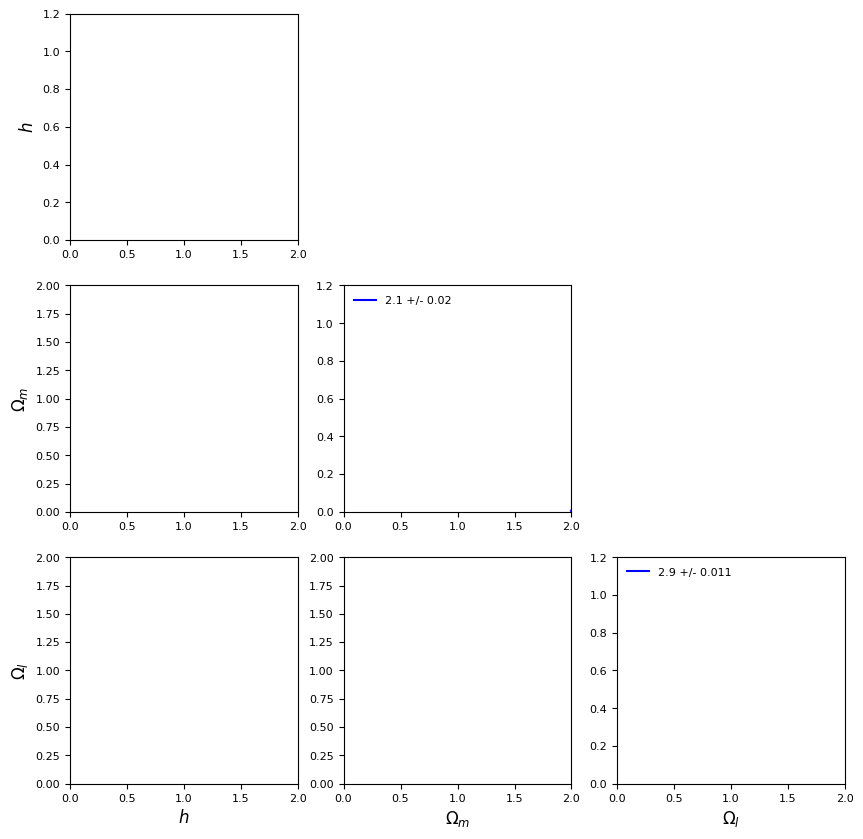

In [55]:
rc('figure',figsize=(10,10))
sm = 1.5   #smoothing parameter - to be adjusted not to change the shape
cs.matrixplot(chain, ['h', 'om', 'ol'], 'blue', sm,
              limits = [[0,2], [0,2],[0,2]], labels=[r'$h$', r'$\Omega_m$',r'$\Omega_l$'])

print(chain)

#### Overplot the True Values
subplot(3,3,1).set_ylabel(r'$h$')
# subplot(3,3,1)
# # plot([2,2], [0,2], 'k--')
# subplot(3,3,4)
# plot([3,3], [0,2], 'k--')
# subplot(3,3,8).autoscale()